In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

In [2]:
df=pd.read_csv('paindata2.csv')
print (len(df))

10300


In [3]:
#Feature normalization according to subjects
featcols=['feat1','feat2','feat3','feat4','feat5']
zscore =lambda x: (x - x.mean()) / x.std()

subject_wise_normlized = df.copy()
dfs=df.copy()

#This will normalize the features only
dfs[featcols] = dfs[featcols].transform(zscore)
    
# subject_wise_normliz & feature wise normalize

subject_wise_normlized[featcols] = subject_wise_normlized[featcols].groupby(subject_wise_normlized.subject).transform(zscore)
subject_wise_normlized.head()


,subject,test,label,label_time,feat1,feat2,feat3,feat4,feat5
0,1,1,1,1,1.524262,-0.666343,-0.549833,-1.246646,0.051625
1,1,1,1,2,1.524262,-0.664841,0.002227,-1.229926,-0.443984
2,1,1,1,3,0.984724,-0.663184,-0.005266,-1.211983,1.139869
3,1,1,1,4,0.911751,-0.661525,3.078269,-1.194518,0.060341
4,1,1,1,5,1.098743,-0.659985,1.182690,-1.178714,0.383784


In [4]:
dfs.head()

,subject,test,label,label_time,feat1,feat2,feat3,feat4,feat5
0,1,1,1,1,2.032600,-0.331928,-0.419423,-0.735973,0.092354
1,1,1,1,2,2.032600,-0.331814,-0.187544,-0.728177,-0.150832
2,1,1,1,3,1.814927,-0.331688,-0.190691,-0.719811,0.626335
3,1,1,1,4,1.785487,-0.331563,1.104468,-0.711668,0.096631
4,1,1,1,5,1.860927,-0.331446,0.308279,-0.704299,0.255338


In [5]:
# implementation  of C_index
def c_index (true_labels, predictions):
    n = 0
    h_sum =0
    
    for i in range(len(true_labels)):
        t = true_labels[i]
        p = predictions[i]
        
        
        for j in range(i+1, len(true_labels)):
            nt = true_labels[j]
            np = predictions[j]
            
            if( t!=nt):
                n += 1
                
                if(p < np and t <  nt) or (p > np and t > nt):
                    h_sum += 1
                
                elif(p == np):
                    h_sum += 0.5
                
    c_index = h_sum/n
    return c_index

# Leave Subject Out Cross Validation

In [6]:
def leave_subject_out(dataset):
    
    c_index_dic={} #This will store the c index values for each subject
    pred_class_each=[]
    all_predict = np.array([])
    true_class_each=[]
    for x in range(1,len(dataset.subject.unique())+1):
        test_data= dataset[dataset['subject'] == x] #Test and train data are complementary
        train_data=dataset[dataset['subject'] !=x]
        
        
        #Defining the train and test data. Only the feature and target columns are considered.
        featcols=['feat1','feat2','feat3','feat4','feat5']
        x_test=test_data[featcols]
        #print (len(x_test))
        y_test=test_data['label']
        x_train=train_data[featcols]
        y_train=train_data['label']
        
        
        #Fitting the knn model and predicting c indexes for each subject
        knn=KNeighborsClassifier(n_neighbors=37, metric='euclidean')
        knn.fit(x_train,y_train)
        pred_class=knn.predict(x_test)
        all_predict = np.concatenate([all_predict, pred_class])
        true_class_each.append(y_test.values)
        
       #Calling the c index function for evaluation
        c_ind= c_index(y_test.values, pred_class)
        c_index_dic[x]= c_ind # c index of each subject 

    ci_df = pd.DataFrame(list(c_index_dic.items()), columns=['subject_id', 'c-index']) #c index of each subject in dataframe
    pred_df=pd.DataFrame({'Predicted Class':pred_class_each})
    true_df=pd.DataFrame({'True Class':true_class_each})
    final=pd.concat([ci_df,pred_df,true_df],axis=1)
    final_df=pd.concat([ci_df,pred_df],axis=1)
    #Q.n. 5. Returning predicted values and c index for each subject
    return all_predict,ci_df
        
    
 

In [7]:
#Q.n. 6. I am calling the above function to return predicted values and CI for both data. 
for x in zip([subject_wise_normlized,dfs],['subjectwise normalized','feature wise normalized']):
    pred_vals,ci=leave_subject_out(x[0])
    print('Predicted values and CI of ',x[1],'\n',pred_vals,ci,'\n')

Predicted values and CI of  subjectwise normalized 
 [2. 2. 2. ... 3. 2. 2.]     subject_id   c-index
0            1  0.757307
1            2  0.577981
2            3  0.528985
3            4  0.675082
4            5  0.635554
5            6  0.522252
6            7  0.648489
7            8  0.697434
8            9  0.524919
9           10  0.573981
10          11  0.698804
11          12  0.640144
12          13  0.674085
13          14  0.562218
14          15  0.760621
15          16  0.709864
16          17  0.684865
17          18  0.699061
18          19  0.630150
19          20  0.498475
20          21  0.645309
21          22  0.533840
22          23  0.677152
23          24  0.534289
24          25  0.597880
25          26  0.589823
26          27  0.683781
27          28  0.778379
28          29  0.642633
29          30  0.606944
30          31  0.557418 

Predicted values and CI of  feature wise normalized 
 [2. 2. 2. ... 2. 2. 2.]     subject_id   c-index
0            1  0.

In [8]:
true_label = df['label'].values
true_label

array([1, 1, 1, ..., 3, 3, 3])

In [9]:
#Q. n. 7. C index on whole dataset
for x in zip([subject_wise_normlized,dfs],['subjectwise normalized','feature wise normalized']):
    labels,ci=leave_subject_out(x[0])
    print('C-index for ',x[1],'\n',c_index(labels,true_label),'\n')


C-index for  subjectwise normalized 
 0.6423838292434334 

C-index for  feature wise normalized 
 0.5756246051722591 



In [10]:
pred1,sub_ci=leave_subject_out(subject_wise_normlized)
pred2,feature_ci=leave_subject_out(dfs)



In [11]:
#Q. n. 8. C index for the first dataset
print('The highest c-index for Subjectwise normalized data is:',sub_ci.max()[1])
print('\n')
print('The lowest c-index for Subjectwise normalized data is:',sub_ci.min()[1])
print('\n')
print('The mean c-index for subjectwise normalized data is:',sub_ci.mean()[1])


The highest c-index for Subjectwise normalized data is: 0.7783792928438504


The lowest c-index for Subjectwise normalized data is: 0.49847541472983925


The mean c-index for subjectwise normalized data is: 0.6305715884921627


In [12]:
#Q.8 C index for all data(featurewise normalized)
print('The highest c-index for Subjectwise normalized data is:',feature_ci.max()[1])
print('\n')
print('The lowest c-index for Subjectwise normalized data is:',feature_ci.min()[1])
print('\n')
print('The mean c-index for subjectwise normalized data is:',feature_ci.mean()[1])

The highest c-index for Subjectwise normalized data is: 0.6949639228390517


The lowest c-index for Subjectwise normalized data is: 0.41371887966804977


The mean c-index for subjectwise normalized data is: 0.5507423247809385


In [13]:
# #Q. N. 10. Real label vs predicted label for subjectwise and featurewise normalized data
# import matplotlib.pyplot as plt
# axes=plt.figure(figsize=(7,5))

# x=true_label

# for i in zip([subject_wise_normlized,dfs],['subjectwise normalized','feature wise normalized']):
#     labels,ci=leave_subject_out(i[0])
#     y=labels
       
#     #print(pd.DataFrame({'true_label':x,'predicted':y}))

#     plt.plot(x,y)
    
    
#     plt.title('Plot for '+i[1])
#     plt.show()

(-0.5, 32.5)


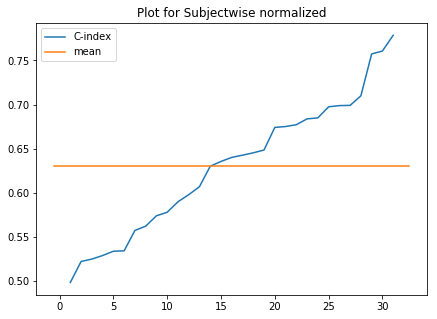

(-0.5, 32.5)


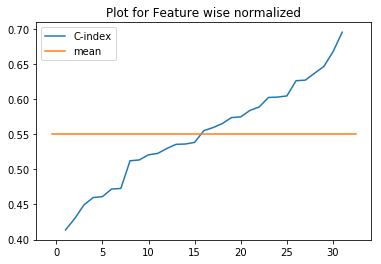

In [14]:
#Checking the performance. The plot shows highest, lowest and the average values and the overall variation of c indexes.
import matplotlib.pyplot as plt
axes=plt.figure(figsize=(7,5))


for i in zip([sub_ci,feature_ci],['Subjectwise normalized','Feature wise normalized']):
    y= i[0]['c-index'].sort_values()
    x= i[0]['subject_id']

    plt.plot(x,y,label='C-index')
    axes=plt.gca()  #get the limit of x and y axis (-0.5, 32.5)
    print(axes.get_xlim())
    
    
    plt.plot(axes.get_xlim(), [i[0]['c-index'].mean(),i[0]['c-index'].mean()],label='mean')#This will draw the mean line
    plt.title('Plot for '+i[1])
    plt.legend()
    plt.show()

# Conclusion
Here I have used the sklearn library for fitting the KNN algorithm. Here the features are normalized subject wise. I have calculated the highest and lowest values of c indexes and the mean. Because each person feels pain differently, the highest and lowest c index varies a lot.

#Q. N. 9
1) Each subject has different biosignal data, they have difference in pain sensation. Some people can feel more pain than others. So the average for subject wise will be different than subjects taken all at once. 

2) We can see that the average value for subjectwise normalized data is higher than for the dataframe normalized at once.

3) Also, we can see that the minimum and maximum c index for subjectwise is higher than for the dataframe normalized at once. 